In [94]:
import pandas as pd
import numpy as np
from gensim.models import Word2Vec
from nltk.tokenize import TweetTokenizer
from nltk.tokenize.casual import reduce_lengthening
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.corpus import stopwords
from math import ceil
from sklearn.metrics import f1_score, classification_report, confusion_matrix, accuracy_score, precision_score, recall_score
import string
from math import log10
from scipy.stats import norm
import re
import pickle
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
columns = ['tweet_id','timestamp','tweet_text','user_id',
           'tweet_coords','tweet_coords_list','tweet_long','tweet_lat','location',
           'enc_url','tweet_lang','hashtags']
tweet_full = pd.read_csv(r'./tweetCoords.csv',
                         header=None,
                         names=columns,
                         parse_dates=[1],
                         infer_datetime_format=True,
                         index_col='timestamp')

In [3]:
related_words = pd.DataFrame()
tweet_date = pd.to_datetime("2017-09-10 00:00:00")
date_delta = pd.Timedelta("24HR")
end_date = pd.to_datetime("2017-09-10 00:00:00")

In [4]:
tweet_full_en = tweet_full[tweet_full['tweet_lang'] == 'en']

In [5]:
tweet_text = tweet_full_en.loc[tweet_date:tweet_date + date_delta,"tweet_text"]

In [129]:
tweet_stops = stopwords.words('english')
# tweet_tokenizer = TweetTokenizer(strip_handles=True,preserve_case=False,reduce_len=True)

def clean_tweet(tweet):
#     takes input string and converts or removes characters depending on settings.
#     returns a string
#     convert case:
    tweet = tweet.lower()
#     remove URLs:
    tweet = re.sub('https?://\S+','',tweet)
#     remove @mentions, including those with a leading '-' or '.' : 
    tweet = re.sub('[-\.]?@\w+','',tweet)
#     remove punctuation, but not hashtags:
    tweet = tweet.translate(tweet.maketrans('','',string.punctuation.replace("#","")))
#     remove non-hashtag '#'.
    tweet = re.sub('\B#\B','',tweet)
#     remove 'amp', 'gt', 'lt', indicating decoded ampersand, greater-than, less-than characters
#     tweet = re.sub(r'\b(amp|gt|lt)\b','',tweet)
#     drop numbers and words of < 4 characters.
    tweet = re.sub(r'\b(?<!#)\w{1,3}\b','',tweet)
    tweet = re.sub(r'\b(?<!#)\d+\b','',tweet)
    return tweet

def tokens_no_stopwords(tweet_as_string):
#     wrapper function that combines the tokenizer, cleaner, and stopword removal.
#     takes a string and returns a list of strings
    cleaned_tweet = clean_tweet(tweet_as_string)
    tweet_reduce_len = reduce_lengthening(cleaned_tweet)
#     tweet_as_tokens = word_tokenize(tweet_reduce_len)
    tweet_as_tokens = tweet_reduce_len.split()
    tweet_no_stops = [word for word in tweet_as_tokens if word not in tweet_stops]
    
    return tweet_no_stops

In [120]:
re.sub(r'\B#\B','','# #34 4#3 6#36')

' #34 4#3 6#36'

In [133]:
text="this is a tweet # #### ####1 #hashtag #123 #12345 apm yooooo"
tokens_no_stopwords(text)

['tweet', '#1', '#hashtag', '#123', '#12345', 'yooo']

## Word/Token Statistics

In [132]:
word_counts = tweet_text.str.split("\s+").apply(pd.Series).stack().value_counts()

In [134]:
word_counts.size

43387

In [143]:
word_counts.head(20)

the        4900
I          4133
to         3853
@          3337
a          3020
in         2998
and        2843
of         2796
is         2619
           2463
for        1977
my         1943
s          1772
you        1647
Florida    1592
this       1572
on         1491
t          1357
from       1236
it         1202
dtype: int64

In [139]:
# tweet_reduce_len = TweetTokenizer(reduce_len=True)
word_counts_reduce = tweet_text.apply(reduce_lengthening).str.split().apply(pd.Series).stack().value_counts()

In [140]:
word_counts_reduce.size

43254

In [144]:
word_counts_reduce.head(20)

the        4900
I          4133
to         3853
@          3337
a          3020
in         2998
and        2843
of         2796
is         2619
for        1977
my         1943
s          1772
you        1647
Florida    1592
this       1572
on         1491
t          1357
from       1236
it         1202
at         1129
dtype: int64

In [145]:
word_counts_full_tokenizer = tweet_text.apply(tweet_tokenizer.tokenize).apply(pd.Series).stack().value_counts()

In [146]:
word_counts_full_tokenizer.size

30594

In [147]:
word_counts_full_tokenizer.head(20)

.                 7696
,                 6587
the               5805
i                 4610
to                4006
@                 3339
a                 3324
in                3265
and               3045
of                2860
is                2755
my                2456
this              2302
for               2093
you               2077
s                 1871
florida           1805
it                1746
#hurricaneirma    1631
on                1610
dtype: int64

In [148]:
word_counts_full_token_clean = tweet_text.apply(tokens_no_stopwords).apply(pd.Series).stack().value_counts()

In [18]:
tokenized_tweets = tweet_text.apply(tokens_no_stopwords)

In [108]:
tweet_test = tweet_text.loc['2017-09-10 00:03:40'][1]
tweet_test = tweet_test.lower()
print(word_tokenize(tweet_test))
print(tweet_test.split())
i=0
print(f"S: {tweet_test}");i+=1
#     1: remove URLs:
tweet_test = re.sub('https?://\S+','',tweet_test)
print(f"{i}: {tweet_test}");i+=1
#     2: remove @mentions, including those with a leading '-' or '.' : 
tweet_test = re.sub('[-\.]?@\w+','',tweet_test)
print(f"{i}: {tweet_test}");i+=1
#     3: remove punctuation, but not hashtags:
tweet_test = tweet_test.translate(tweet_test.maketrans('','',string.punctuation.replace("#","")))
print(f"{i}: {tweet_test}");i+=1
#     4: remove non-hashtag '#'.
# tweet_test = re.sub('#\B','',tweet_test)
print(f"{i}: {tweet_test}");i+=1
#     5: remove 'amp', 'gt', 'lt', indicating decoded ampersand, greater-than, less-than characters
# tweet_test = re.sub(r'\b(amp|gt|lt)\b','',tweet_test)
print(f"{i}: {tweet_test}");i+=1
#     6: drop words of < 4 characters, but not hashtags
tweet_test = re.sub(r'\b(?<!#)\w{1,3}\b','',tweet_test)
print(f"{i}: {tweet_test}");i+=1
#     7: drop numbers, but not hashtags
tweet_test = re.sub(r'\b(?<!#)\d+\b','',tweet_test)
print(f"{i}: {tweet_test}");i+=1

print(word_tokenize(tweet_test))

['tagged', '2017', '#', '1', '@', 'us', '1-biscayne', 'blvd', '.', 'https', ':', '//t.co/1foe57dvyc']
['tagged', '2017', '#1', '@', 'us', '1-biscayne', 'blvd.', 'https://t.co/1foe57dvyc']
S: tagged 2017  #1 @ us 1-biscayne blvd. https://t.co/1foe57dvyc
1: tagged 2017  #1 @ us 1-biscayne blvd. 
2: tagged 2017  #1 @ us 1-biscayne blvd. 
3: tagged 2017  #1  us 1biscayne blvd 
4: tagged 2017  #1  us 1biscayne blvd 
5: tagged 2017  #1  us 1biscayne blvd 
6: tagged 2017  #1   1biscayne blvd 
7: tagged   #1   1biscayne blvd 
['tagged', '#', '1', '1biscayne', 'blvd']


In [158]:
date_test = '2017-09-10 00:03:40'
print(tweet_text.loc[date_test].apply(reduce_lengthening))
print(tweet_text.loc[date_test].apply(tokens_no_stopwords))


timestamp
2017-09-10 00:03:40    #NaturalRemedies This Is the Only Product That...
2017-09-10 00:03:40    TAGGED 2017  #1 @ US 1-Biscayne Blvd. https://...
Name: tweet_text, dtype: object
timestamp
2017-09-10 00:03:40    [#naturalremedies, product, kills, viruses, fu...
2017-09-10 00:03:40                        [tagged, #1, 1biscayne, blvd]
Name: tweet_text, dtype: object


In [32]:
tokenized_tweets[tokenized_tweets.apply(lambda x: '@' in x)]

Series([], Name: tweet_text, dtype: object)

In [149]:
word_counts_full_token_clean.size

16952

In [150]:
word_counts_full_token_clean.head(20)

florida           1764
#hurricaneirma    1615
irma              1340
hurricane         1294
#irma             1189
reports            809
storm              742
power              677
rain               632
like               628
wind               628
safe               619
gust               552
asos               544
beach              531
miami              531
knots              509
county             493
still              491
good               423
dtype: int64

In [151]:
tweet_len = tweet_text.groupby(tweet_text.str.split().apply(len)).size()

In [152]:
tweet_len_post = tweet_text.apply(tokens_no_stopwords).apply(len).value_counts().sort_index()

In [153]:
tweet_len_post[tweet_len_post.index <= 10].sum()

18109

In [154]:
tweet_len_post.sum()

19089

In [155]:
tweet_len

tweet_text
1       37
2      342
3      622
4      753
5      815
6      911
7      956
8     1052
9     1121
10    1022
11    1020
12    1040
13     988
14    1005
15    1308
16    1112
17     876
18     862
19     736
20     587
21     493
22     349
23     317
24     239
25     151
26     163
27      70
28      68
29      33
30      21
31      12
32       6
33       2
Name: tweet_text, dtype: int64

In [156]:
tweet_len_post

0      249
1     1329
2     1640
3     1768
4     2048
5     1982
6     2159
7     2511
8     2091
9     1452
10     880
11     526
12     257
13     112
14      61
15      17
16       5
17       1
18       1
Name: tweet_text, dtype: int64

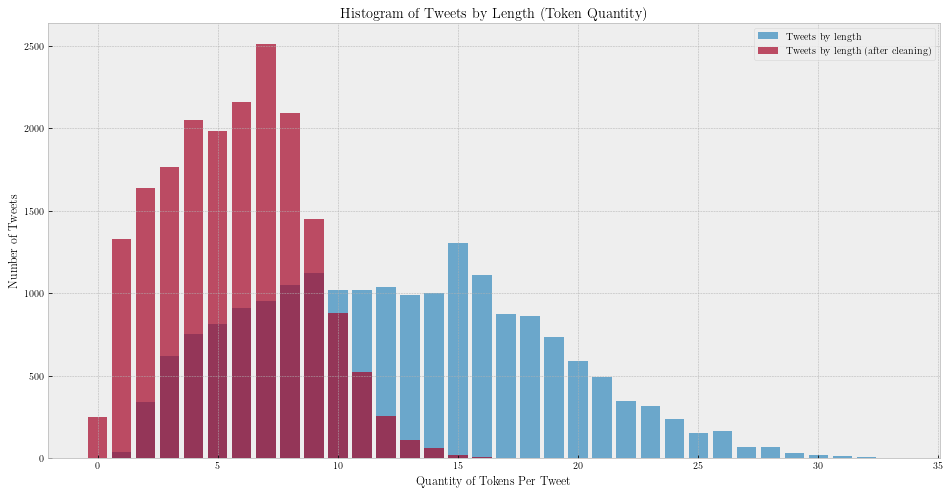

In [157]:
fig_4 = plt.figure(figsize=(16,8))
plt.style.use('bmh')
plt.rc('text', usetex=True)
plt.rc('font', family='serif')
plt.bar(tweet_len.index,tweet_len.values,alpha=.7,label="Tweets by length")
plt.bar(tweet_len_post.index,tweet_len_post.values,alpha=.7,label="Tweets by length (after cleaning)")
plt.xlabel("Quantity of Tokens Per Tweet")
plt.ylabel("Number of Tweets")
plt.title("Histogram of Tweets by Length (Token Quantity)")
plt.legend()
plt.show()
fig_4.savefig(f'./figures/TweetsByLength.pdf',bbox_inches='tight')